In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Reshape

# Define labels and parameters
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 80

# Data loading
def load_data(base_dir, labels, image_size):
    X = []
    y = []
    for label in labels:
        folderPath = os.path.join(base_dir, label)
        for file in tqdm(os.listdir(folderPath), desc=f"Loading {label}"):
            img_path = os.path.join(folderPath, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(labels.index(label))
    return np.array(X), np.array(y)

In [2]:
# Load training and testing data
X_train, y_train = load_data('Training', labels, image_size)
X_test, y_test = load_data('Testing', labels, image_size)

Loading pituitary_tumor: 100%|██████████| 74/74 [00:01<00:00, 37.41it/s]


In [ ]:


# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

# GAN Setup
LATENT_DIM = 100
NUM_CLASSES = len(labels)

# # Generator
# def build_generator():
#     model = Sequential([
#         layers.Dense(10 * 10 * 256, input_dim=LATENT_DIM),
#         layers.Reshape((10, 10, 256)),
#         layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'),
#         layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
#         layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
#     ])
#     return model
def build_generator():
    model = Sequential([
        # Fully connected layer to create an initial feature map
        layers.Dense(10 * 10 * 256, input_dim=LATENT_DIM),
        layers.Reshape((10, 10, 256)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Transposed convolution to upsample
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Another transposed convolution
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Final transposed convolution to get to the target size
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    return model


# Discriminator (your CNN)
def build_discriminator():
    input_img = Input(shape=(image_size, image_size, 3))
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)

    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=input_img, outputs=output)
    return model

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [4]:
# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(LATENT_DIM,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    return Model(gan_input, gan_output)

gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='categorical_crossentropy')

# Train GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        noise = tf.random.normal((batch_size, LATENT_DIM))
        fake_images = generator.predict(noise)
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, real_labels = X_train[idx], y_train[idx]
        combined_images = np.concatenate([real_images, fake_images])
        fake_labels = np.zeros((batch_size, NUM_CLASSES))
        combined_labels = np.concatenate([real_labels, fake_labels])
        d_loss = discriminator.train_on_batch(combined_images, combined_labels)

        misleading_labels = np.zeros((batch_size, NUM_CLASSES))
        g_loss = gan.train_on_batch(noise, misleading_labels)

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")

train_gan(epochs=100, batch_size=32)

# Fine-tune discriminator
discriminator.trainable = True

discriminator.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)
history= discriminator.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[reduce_lr]
)

# discriminator.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/100, D Loss: [array(0.700282, dtype=float32), array(0.59375, dtype=float32)], G Loss: [array(0.700282, dtype=float32), array(0.700282, dtype=float32), array(0.59375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 2/100, D Loss: [array(0.69526994, dtype=float32), array(0.625, dtype=float32)], G Loss: [array(0.69526994, dtype=float32), array(0.69526994, dtype=float32), array(0.625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 3/100, D Loss: [array(0.6965249, dtype=float32), array(0.6145833, dtype=float32)], G Loss: [array(0.6965249, dtype=float32), array(0.6965249, dtype=float32), array(0.6145833, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 4/100, D Loss: [array(0.6949593, dtype=float32), array(0.63671875, dtype=float32)], G Loss: [array(0.6949593, dtype=float32), array(0.6949593, dtype=float32), array(0.63671875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Epoch 5/100, D Loss: [array(0.6948116, dtype=float32), array(0.634375,

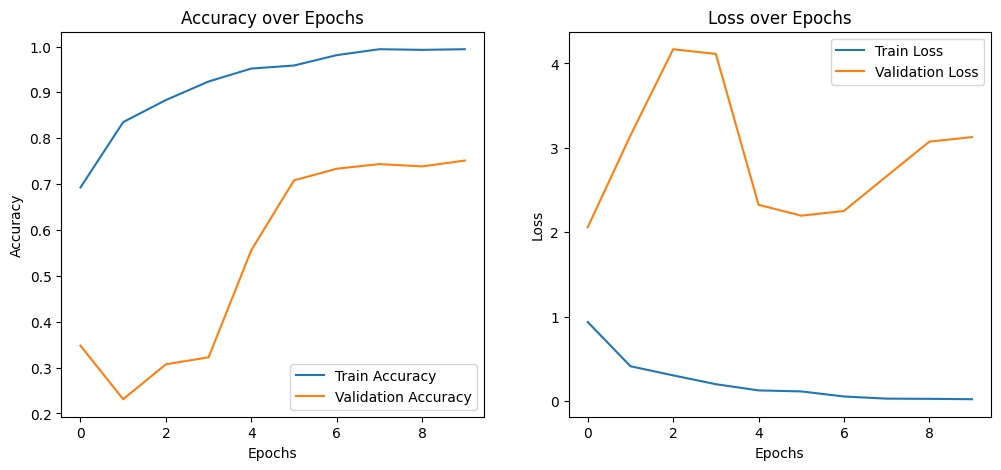

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


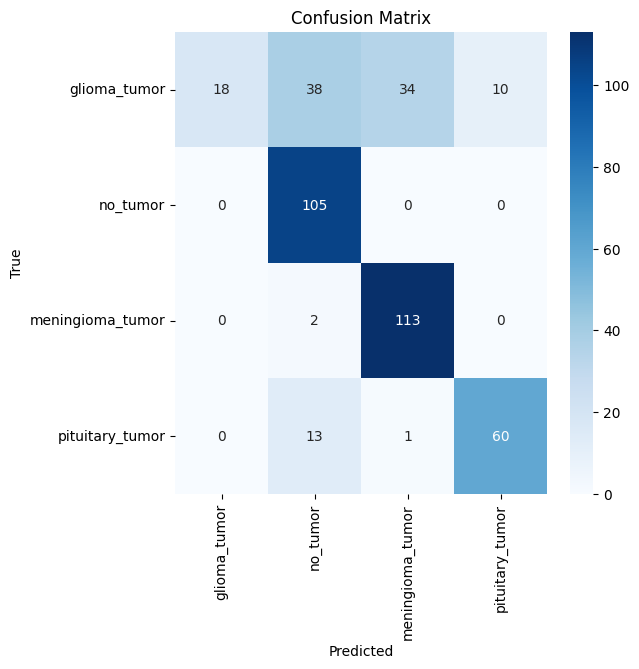

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
        no_tumor       0.66      1.00      0.80       105
meningioma_tumor       0.76      0.98      0.86       115
 pituitary_tumor       0.86      0.81      0.83        74

        accuracy                           0.75       394
       macro avg       0.82      0.74      0.70       394
    weighted avg       0.81      0.75      0.70       394

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


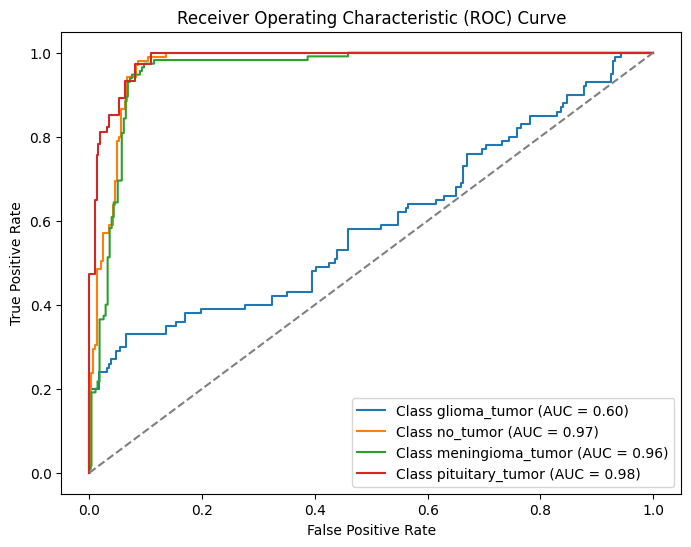

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5339 - loss: 6.5112

Test Loss and Accuracy:
Loss: 3.1273159980773926
Accuracy: 0.7512690424919128
Test Set Accuracy: 0.7513


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import tensorflow as tf

# 1. Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
# 2. Confusion Matrix
y_pred = np.argmax(discriminator.predict(X_test), axis=1)  # Predict the class labels
y_true = np.argmax(y_test, axis=1)  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# 4. ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(labels)

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], discriminator.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 5. Model Evaluation
score = discriminator.evaluate(X_test, y_test, verbose=1)
print("\nTest Loss and Accuracy:")
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")

# 6. Accuracy on the Test Set
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Test Set Accuracy: {accuracy:.4f}")
